In [3]:
# -------------------------------------------------------------------
# Step 0: Setup
# -------------------------------------------------------------------

# Uncomment and adjust to install libraries not available on Google Colab
#!pip install packagename

# Load any libraries used for this project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)

# for stepwise selection later
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression




In [7]:

# Load data
#from google.colab import files  # so we can upload a CSV to our notebook

#uploaded = files.upload() # opens a file chooser to select our csv file


loans = pd.read_csv("Loan Default Prediction2-2.csv")



In [8]:

# Initial structure of the data
print("Structure / dtypes:")
print(loans.info())

print("\nMissing values per column:")
print(loans.isna().sum())

# Note three things:
# 1. We have significant missing values for two variables
# 2. Our outcome variable, SeriousDlqin2yrs, is already in 0/1, no need to make a dummy
# 3. Cust_id is an identifier column, not to be used for analysis



Structure / dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Cust_id            150000 non-null  int64  
 1   SeriousDlqin2yrs   150000 non-null  int64  
 2   Utilization        150000 non-null  float64
 3   Age                150000 non-null  int64  
 4   Num_loans          150000 non-null  int64  
 5   Num_dependents     146076 non-null  float64
 6   MonthlyIncome      120269 non-null  float64
 7   Num_Savings_Accts  150000 non-null  int64  
 8   DebtRatio          150000 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 10.3 MB
None

Missing values per column:
Cust_id                  0
SeriousDlqin2yrs         0
Utilization              0
Age                      0
Num_loans                0
Num_dependents        3924
MonthlyIncome        29731
Num_Savings_Accts        0
DebtRatio                0
dtyp

In [9]:
# Let's drop rows with missing values
loans = loans.dropna()

# Note: from past experience with this data, missingness is NOT random
# So, naively dropping missing values has biased the data
# We will explore this in a later week...

In [10]:
# -------------------------------------------------------------------
# Step 1: Train / Validation / Test split
# -------------------------------------------------------------------

loans_train, loans_test = train_test_split(
    loans,
    test_size=0.30,
    random_state=385
    )






Train summary:
             Cust_id  SeriousDlqin2yrs   Utilization           Age  \
count   84188.000000      84188.000000  84188.000000  84188.000000   
mean    74901.024802          0.068787      5.453445     51.267687   
std     43314.072372          0.253092    220.206645     14.434784   
min         1.000000          0.000000      0.000000     21.000000   
25%     37408.250000          0.000000      0.035352     40.000000   
50%     74708.500000          0.000000      0.177005     51.000000   
75%    112367.250000          0.000000      0.575434     61.000000   
max    150000.000000          1.000000  29110.000000    103.000000   

          Num_loans  Num_dependents  MonthlyIncome  Num_Savings_Accts  \
count  84188.000000    84188.000000   8.418800e+04       84188.000000   
mean       8.751128        0.852746   6.686484e+03           1.050245   
std        5.160348        1.152096   1.651625e+04           1.145509   
min        0.000000        0.000000   0.000000e+00           

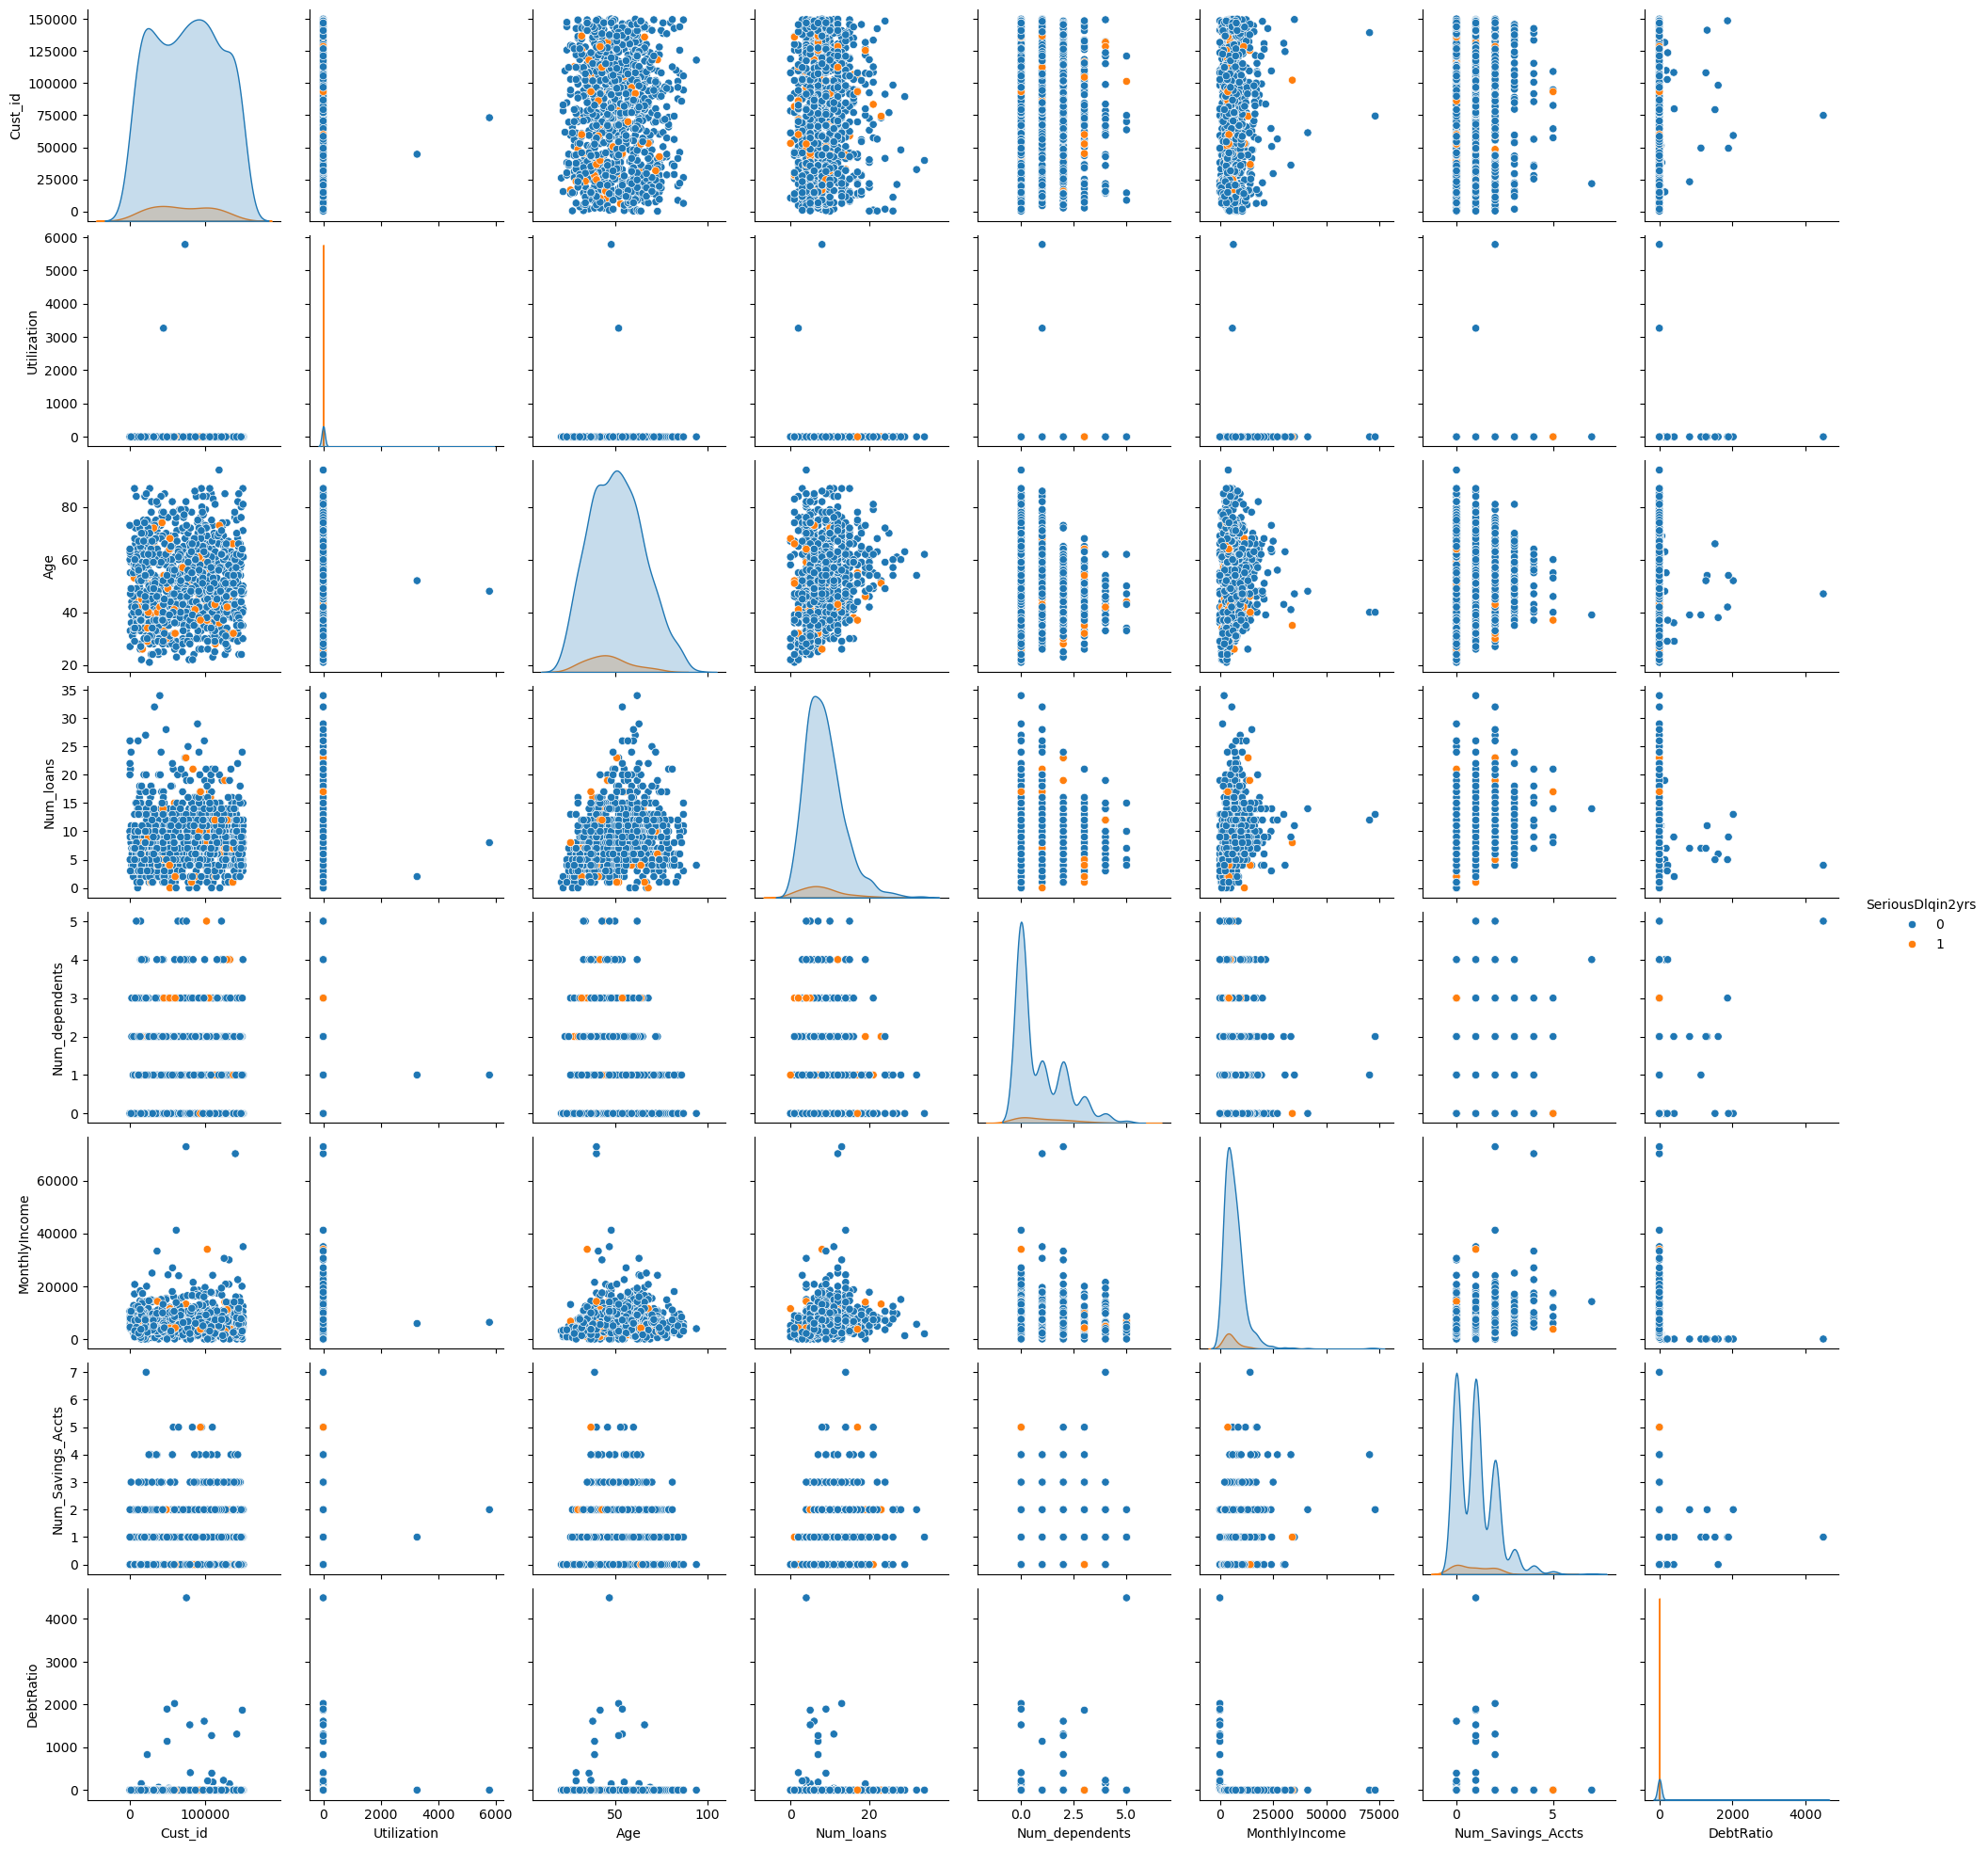

In [11]:
# -------------------------------------------------------------------
# Step 2: EDA
# -------------------------------------------------------------------

# summary statistics
print("\nTrain summary:")
print(loans_train.describe())

# set a numpy random seed and then sample rows to keep plots light
np.random.seed(8675309)

sample_idx = np.random.choice(loans_train.index, size=min(1000, len(loans_train)), replace=False)

# Pairs plot of our data, colored by our outcome variable
sns.pairplot(
    loans_train.loc[sample_idx].assign(
        SeriousDlqin2yrs = loans_train.loc[sample_idx, "SeriousDlqin2yrs"].astype("category")
    ),
    hue='SeriousDlqin2yrs',
    diag_kind='kde'
    )

plt.show()



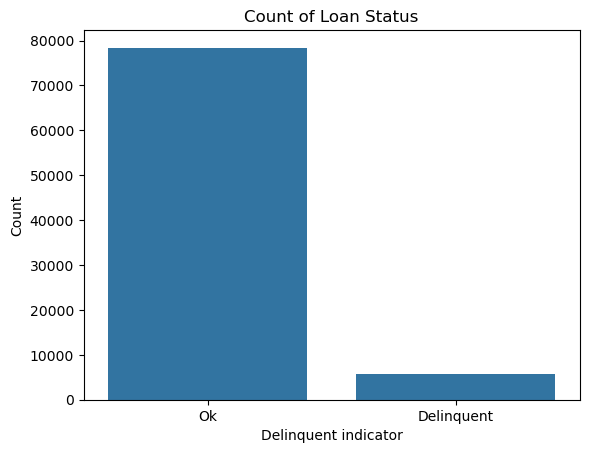

In [12]:
# Do we have imbalanced classes? Yes!
# The mean of SeriousDlqin2yrs is ~0.07 or 7%
# If we train a model on severly imbalanced classes, it likely won't be very
# good. The signal of the majority class will overwhelm the minority.

# Make a labeled version of SeriousDlqin2yrs to make plotting easier
loans_train["delinquent_label"] = loans_train["SeriousDlqin2yrs"].map({0: "Ok", 1: "Delinquent"})


# Basic bar plot of SeriousDlqin2yrs
sns.countplot(data=loans_train, x="delinquent_label")
plt.xlabel("Delinquent indicator")
plt.ylabel("Count")
plt.title("Count of Loan Status")
plt.show()

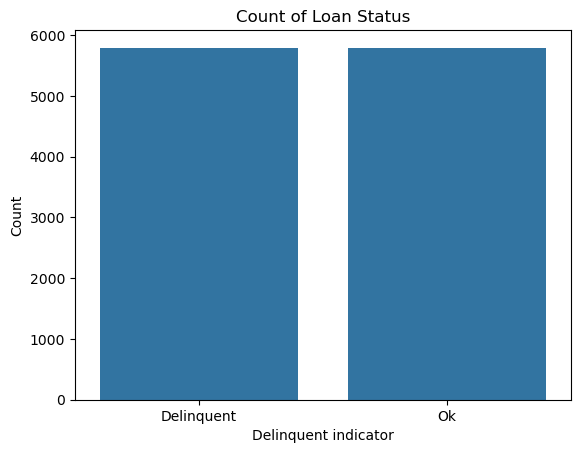

In [13]:
# -------------------------------------------------------------------
# Step 3: Pre-processing
# -------------------------------------------------------------------

# Class imbalance: downsample the negative class; keep all positives
# + equal number of negatives
pos_idx = loans_train.index[loans_train["SeriousDlqin2yrs"] == 1]
neg_idx = loans_train.index[loans_train["SeriousDlqin2yrs"] == 0]

keep_neg = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
keep_idx = np.concatenate([pos_idx, keep_neg])

loans_train_bal = loans_train.loc[keep_idx].copy()

# Quick look after balancing
sns.countplot(data=loans_train_bal, x="delinquent_label")
plt.xlabel("Delinquent indicator")
plt.ylabel("Count")
plt.title("Count of Loan Status")
plt.show()



In [14]:
# -------------------------------------------------------------------
# Step 4: Feature Engineering
# -------------------------------------------------------------------

# Let's create polynomial terms and then use stepwise selection below
# to see if we want to keep them in the model

# balanced dataset for training
loans_train_bal["Num_loans_sq"] = loans_train_bal["Num_loans"]**2
loans_train_bal["Age_sq"] = loans_train_bal["Age"]**2
loans_train_bal["Num_dependents_sq"] = loans_train_bal["Num_dependents"]**2
loans_train_bal["MonthlyIncome_sq"] = loans_train_bal["MonthlyIncome"]**2
loans_train_bal["Num_Savings_Accts_sq"] = loans_train_bal["Num_Savings_Accts"]**2
loans_train_bal["DebtRatio_sq"] = loans_train_bal["DebtRatio"]**2

# unbalanced training set for in-sample validation (albeit with different sample)
loans_train["Num_loans_sq"] = loans_train["Num_loans"]**2
loans_train["Age_sq"] = loans_train["Age"]**2
loans_train["Num_dependents_sq"] = loans_train["Num_dependents"]**2
loans_train["MonthlyIncome_sq"] = loans_train["MonthlyIncome"]**2
loans_train["Num_Savings_Accts_sq"] = loans_train["Num_Savings_Accts"]**2
loans_train["DebtRatio_sq"] = loans_train["DebtRatio"]**2


# don't forget to apply to our test set too
loans_test["Num_loans_sq"] = loans_test["Num_loans"]**2
loans_test["Age_sq"] = loans_test["Age"]**2
loans_test["Num_dependents_sq"] = loans_test["Num_dependents"]**2
loans_test["MonthlyIncome_sq"] = loans_test["MonthlyIncome"]**2
loans_test["Num_Savings_Accts_sq"] = loans_test["Num_Savings_Accts"]**2
loans_test["DebtRatio_sq"] = loans_test["DebtRatio"]**2


In [15]:
loans_train_bal

,Cust_id,SeriousDlqin2yrs,Utilization,Age,Num_loans,Num_dependents,MonthlyIncome,Num_Savings_Accts,DebtRatio,delinquent_label,Num_loans_sq,Age_sq,Num_dependents_sq,MonthlyIncome_sq,Num_Savings_Accts_sq,DebtRatio_sq
85609,85610,1,0.673091,24,2,0.0,1808.0,0,0.276396,Delinquent,4,576,0.0,3268864.0,0,0.076395
133526,133527,1,0.718918,48,12,1.0,11200.0,1,0.189358,Delinquent,144,2304,1.0,125440000.0,1,0.035856
39696,39697,1,0.016766,46,6,0.0,4876.0,2,0.664958,Delinquent,36,2116,0.0,23775376.0,4,0.442169
32209,32210,1,0.833739,35,7,0.0,4162.0,0,0.423733,Delinquent,49,1225,0.0,17322244.0,0,0.179550
49992,49993,1,1.000000,43,6,1.0,3200.0,0,0.280225,Delinquent,36,1849,1.0,10240000.0,0,0.078526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133591,133592,0,0.150933,47,7,0.0,12992.0,1,0.284384,Ok,49,2209,0.0,168792064.0,1,0.080874
8664,8665,0,0.148596,34,10,2.0,15833.0,2,0.113932,Ok,100,1156,4.0,250683889.0,4,0.012981
83665,83666,0,0.078946,53,6,2.0,12906.0,1,0.229875,Ok,36,2809,4.0,166564836.0,1,0.052843
75604,75605,0,0.826615,23,6,0.0,2959.0,0,0.038176,Ok,36,529,0.0,8755681.0,0,0.001457


In [16]:
# -------------------------------------------------------------------
# Step 5: Feature & Model Selection
# Model f1 on balanced TRAIN, drop an ID column if present (Cust_id)
# -------------------------------------------------------------------

# get a vector of predictor variables to use for modeling
predictors = loans_train_bal.columns.tolist()

predictors.remove("SeriousDlqin2yrs")

predictors.remove("Cust_id")

predictors.remove("delinquent_label")


predictors



['Utilization',
 'Age',
 'Num_loans',
 'Num_dependents',
 'MonthlyIncome',
 'Num_Savings_Accts',
 'DebtRatio',
 'Num_loans_sq',
 'Age_sq',
 'Num_dependents_sq',
 'MonthlyIncome_sq',
 'Num_Savings_Accts_sq',
 'DebtRatio_sq']

In [17]:
# build the base model with all predictors
f1 = sm.Logit(loans_train_bal["SeriousDlqin2yrs"], sm.add_constant(loans_train_bal[predictors])).fit()

# get a summary
print("\n=== f1 summary ===")
print(f1.summary())


Optimization terminated successfully.
         Current function value: 0.662154
         Iterations 8

=== f1 summary ===
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                11582
Model:                          Logit   Df Residuals:                    11568
Method:                           MLE   Df Model:                           13
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                 0.04471
Time:                        21:11:14   Log-Likelihood:                -7669.1
converged:                       True   LL-Null:                       -8028.0
Covariance Type:            nonrobust   LLR p-value:                5.051e-145
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4599      0.225      2.045      0.041    

In [18]:

# This function takes your fitted model as input
# It iterates across all variables
# And it produces a pandas data frame of VIFs for each variable
def vif_table(model):
    X = model.model.exog
    names = model.model.exog_names
    vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return pd.DataFrame({"variable": names, "VIF": vif_values})


vif_df = vif_table(f1)

print("\nVIF (f1):")
print(vif_df)







VIF (f1):
                variable        VIF
0                  const   0.000000
1            Utilization   1.000859
2                    Age  41.337954
3              Num_loans   6.886313
4         Num_dependents   4.871861
5          MonthlyIncome  12.036491
6      Num_Savings_Accts   3.069983
7              DebtRatio   3.197765
8           Num_loans_sq   6.084288
9                 Age_sq  41.255515
10     Num_dependents_sq   4.644185
11      MonthlyIncome_sq  11.968450
12  Num_Savings_Accts_sq   2.505052
13          DebtRatio_sq   3.195173


c:\Users\liula\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [19]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on training data
train_probs = f1.predict(sm.add_constant(loans_train[predictors]))



# calculate precision and recall
train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(loans_train['SeriousDlqin2yrs'], train_pred_class)
precision_train = precision_score(loans_train['SeriousDlqin2yrs'], train_pred_class)
recall_train = recall_score(loans_train['SeriousDlqin2yrs'], train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")







In-sample confusion matrix (threshold = 0.5):
          Pred 0  Pred 1
Actual 0   42593   35804
Actual 1    1932    3859

Precision (train): 0.097
Recall (train):    0.666


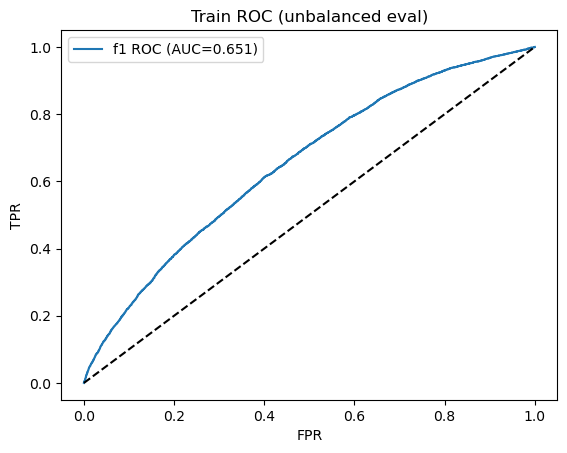

AUC (f1, train on unbalanced eval): 0.651


In [20]:
# ROC & AUC
fpr, tpr, _ = roc_curve(loans_train['SeriousDlqin2yrs'], train_probs)
auc_f1 = roc_auc_score(loans_train['SeriousDlqin2yrs'], train_probs)

plt.plot(fpr, tpr, label=f"f1 ROC (AUC={auc_f1:.3f})")
plt.plot([0,1],[0,1], "k--")
plt.legend(); plt.title("Train ROC (unbalanced eval)"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()
print(f"AUC (f1, train on unbalanced eval): {auc_f1:.3f}")

In [21]:
# Looking at Precision/RecallROC/AUC above, we could clearly get a better model

# -------------------------------------------------------------------
# Stepwise-like selection with mlxtend (wrapper around sklearn)
# We use LogisticRegression (sklearn) + AUC scoring. Then refit in statsmodels.
# -------------------------------------------------------------------

# this takes a long time, so let's do this on a random sample of 1,000 obs
stepwise_sample = loans_train_bal.sample(n=1000, random_state=385)

stepwise_sample = stepwise_sample[predictors + ['SeriousDlqin2yrs']]

stepwise_model = SFS(
    LogisticRegression(solver="lbfgs", max_iter=1000),
    k_features = "best", # we can let the model choose or set a range as before
    forward = True,
    floating = True,
    scoring = "roc_auc", # maximum AUC
    cv = 5,
    n_jobs = -1 # use all available cores to build models in parallel
)

stepwise_model = stepwise_model.fit(
    stepwise_sample[predictors],
    stepwise_sample["SeriousDlqin2yrs"]
    )

# get selected predictors
selected_idx = list(stepwise_model.k_feature_idx_)

selected_cols = [predictors[i] for i in selected_idx]

print("Selected features by SFS:", selected_cols)

Selected features by SFS: ['Utilization', 'Age', 'Num_loans', 'MonthlyIncome', 'Num_Savings_Accts', 'DebtRatio', 'Num_loans_sq', 'Age_sq', 'Num_Savings_Accts_sq', 'DebtRatio_sq']


If feature selection takes too long in class, it will choose the following

['Utilization', 'Age', 'Num_loans', 'Num_dependents', 'MonthlyIncome', 'DebtRatio', 'Num_loans_sq', 'Age_sq', 'Num_Savings_Accts_sq', 'DebtRatio_sq']

In [ ]:

# Refit a statsmodels Logit with the selected columns
f2 = sm.Logit(
    loans_train_bal["SeriousDlqin2yrs"],
    sm.add_constant(loans_train_bal[selected_cols])
    ).fit()

# get a summary
print("\n=== f1 summary ===")
print(f2.summary())



In [ ]:
# VIF for the stepwise-selected model
vif_df2 = vif_table(f2)

print("\nVIF (f2):")
print(vif_df2)

In [ ]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on training data
train_probs2 = f2.predict(sm.add_constant(loans_train[selected_cols]))



# calculate precision and recall
train_pred_class2 = (train_probs2 >= 0.5).astype(int)

cm_train2 = confusion_matrix(loans_train['SeriousDlqin2yrs'], train_pred_class2)
precision_train2 = precision_score(loans_train['SeriousDlqin2yrs'], train_pred_class2)
recall_train2 = recall_score(loans_train['SeriousDlqin2yrs'], train_pred_class2)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train2,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train2:.3f}")
print(f"Recall (train):    {recall_train2:.3f}")


In [ ]:
# ROC & AUC
fpr2, tpr2, _ = roc_curve(loans_train['SeriousDlqin2yrs'], train_probs2)
auc_f2 = roc_auc_score(loans_train['SeriousDlqin2yrs'], train_probs2)

plt.plot(fpr2, tpr2, label=f"f2 ROC (AUC={auc_f2:.3f})")
plt.plot([0,1],[0,1], "k--")
plt.legend(); plt.title("Train ROC (unbalanced eval)"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()
print(f"AUC (f2, train on unbalanced eval): {auc_f2:.3f}")

In [ ]:
# That wasn't any better, let's use our own judgment

# -------------------------------------------------------------------
# Pick a final model by judgment
# Drop DebtRatio and its square, drop Age^2
# We'll specify explicitly and fit on the BALANCED TRAIN.
# -------------------------------------------------------------------
final_terms = ["Age", "Num_loans", "Num_dependents",
               "MonthlyIncome", "Num_Savings_Accts",
               "Num_loans_sq", "MonthlyIncome_sq", "Num_Savings_Accts_sq"]



# train one last model
f3 = sm.Logit(
    loans_train_bal["SeriousDlqin2yrs"],
    sm.add_constant(loans_train_bal[final_terms])
    ).fit()

# get a summary
print("\n=== f3 summary ===")
print(f3.summary())





In [ ]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on training data
train_probs3 = f3.predict(sm.add_constant(loans_train[final_terms]))



# calculate precision and recall
train_pred_class3 = (train_probs3 >= 0.5).astype(int)

cm_train3 = confusion_matrix(loans_train['SeriousDlqin2yrs'], train_pred_class3)
precision_train3 = precision_score(loans_train['SeriousDlqin2yrs'], train_pred_class3)
recall_train3 = recall_score(loans_train['SeriousDlqin2yrs'], train_pred_class3)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train3,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train3:.3f}")
print(f"Recall (train):    {recall_train3:.3f}")


# ROC & AUC
fpr3, tpr3, _ = roc_curve(loans_train['SeriousDlqin2yrs'], train_probs3)
auc_f3 = roc_auc_score(loans_train['SeriousDlqin2yrs'], train_probs3)

plt.plot(fpr3, tpr3, label=f"f2 ROC (AUC={auc_f3:.3f})")
plt.plot([0,1],[0,1], "k--")
plt.legend(); plt.title("Train ROC (unbalanced eval)"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()
print(f"AUC (f3, train on unbalanced eval): {auc_f3:.3f}")

In [ ]:
# -------------------------------------------------------------------
# Step 6: Test set evaluation
# -------------------------------------------------------------------

# predictions for our three models
test_probs1 = f1.predict(sm.add_constant(loans_test[predictors]))

test_probs2 = f2.predict(sm.add_constant(loans_test[selected_cols]))

test_probs3 = f3.predict(sm.add_constant(loans_test[final_terms]))


# calc AUC etc. for our 3 models
auc_test1 = roc_auc_score(loans_test["SeriousDlqin2yrs"], test_probs1)

auc_test2 = roc_auc_score(loans_test["SeriousDlqin2yrs"], test_probs2)

auc_test3 = roc_auc_score(loans_test["SeriousDlqin2yrs"], test_probs3)

test_auc_df = pd.DataFrame({
    "Model": ["f1", "f2", "f3"],
    "AUC": [auc_test1, auc_test2, auc_test3]
})

test_auc_df
